In [24]:
import site

site.addsitedir("..")

from pathlib import Path

import pandas as pd
import torch

from src.ai.rollout import *
from src.ai.train import *

In [62]:
outdir = Path("/Users/davidzheng/projects/crew-ai/outdirs/0323/run_0")
outdir2 = Path("/Users/davidzheng/projects/crew-ai/outdirs/0323/run_7")

In [63]:
settings_dict = torch.load(outdir / "settings.pth", weights_only=False)
settings = settings_dict["settings"]
hp = settings_dict["hp"]
models = get_models(hp, settings)
policy_model = models["policy"].eval()
value_model = models["value"].eval()

In [64]:
settings_dict2 = torch.load(outdir2 / "settings.pth", weights_only=False)
settings2 = settings_dict2["settings"]
hp2 = settings_dict2["hp"]
models2 = get_models(hp2, settings2)
policy_model2 = models2["policy"].eval()
value_model2 = models2["value"].eval()

In [56]:
checkpoint = torch.load(outdir / "checkpoint.pth", weights_only=False)
policy_model.load_state_dict(checkpoint["policy_model"])
value_model.load_state_dict(checkpoint["value_model"])
td = checkpoint["td"]
td_train = td[: hp.num_train_rollouts_per_round]
td_val = td[hp.num_train_rollouts_per_round :]

In [65]:
checkpoint2 = torch.load(outdir2 / "checkpoint.pth", weights_only=False)
policy_model2.load_state_dict(checkpoint2["policy_model"])
value_model2.load_state_dict(checkpoint2["value_model"])
td2 = checkpoint2["td"]
td_train2 = td2[: hp2.num_train_rollouts_per_round]
td_val2 = td2[hp2.num_train_rollouts_per_round :]

In [66]:
def entropy(x):
    eps = 1e-8
    log_eps = np.log2(eps)
    clamped_probs = x.clamp(min=eps)
    clamped_log_probs = torch.log2(x).clamp(min=log_eps)
    entropy = -torch.sum(clamped_probs * clamped_log_probs, dim=-1)
    entropy = torch.where(entropy < 3e-6, 0.0, entropy)

    return entropy

In [75]:
td_train["orig_probs"][:, [6, 7, 8], 0].mean(dim=0)

tensor([0.7532, 0.7620, 0.7427])

In [76]:
td_train2["orig_probs"][:, [6, 7, 8], 0].mean(dim=0)

tensor([0.7628, 0.7602, 0.7591])

In [67]:
entropy(td_train["orig_probs"]).mean(dim=0).reshape((-1, 3))

tensor([[1.7383, 1.9355, 2.0436],
        [1.0458, 0.4502, 0.4565],
        [1.0702, 1.0225, 1.0781],
        [1.4361, 0.5355, 0.4999],
        [0.6108, 0.6073, 0.6248],
        [1.0760, 0.5010, 0.5254],
        [0.2693, 0.2468, 0.2703],
        [0.7466, 0.4357, 0.4113],
        [0.0678, 0.0616, 0.0567],
        [0.5820, 0.4541, 0.3959],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

In [68]:
entropy(td_train2["orig_probs"]).mean(dim=0).reshape((-1, 3))

tensor([[1.4912, 1.5583, 1.5551],
        [2.5848, 1.0716, 1.0773],
        [1.1314, 1.1510, 1.1567],
        [2.3218, 1.0699, 1.0574],
        [0.7846, 0.7948, 0.7903],
        [1.9999, 1.0412, 1.0455],
        [0.4643, 0.4772, 0.4653],
        [1.5849, 0.9744, 0.9624],
        [0.2034, 0.1981, 0.2030],
        [0.9999, 0.7098, 0.7033],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

<Axes: >

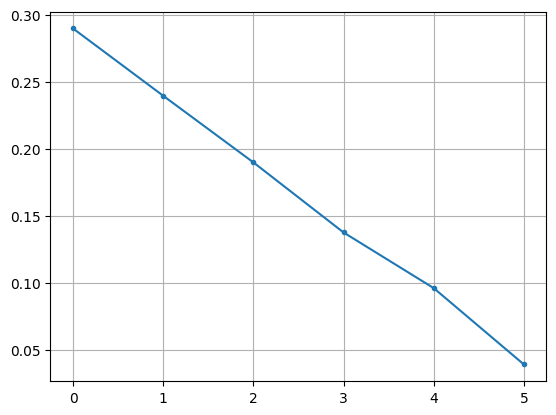

In [79]:
s = pd.Series((td_train2["actions"] != 0).float().mean(dim=0))
s = s.groupby(s.index // 3).mean()
s = s[s.index % 2 == 0]
s.reset_index(inplace=True, drop=True)
s.plot(marker=".", grid=True)

<Axes: >

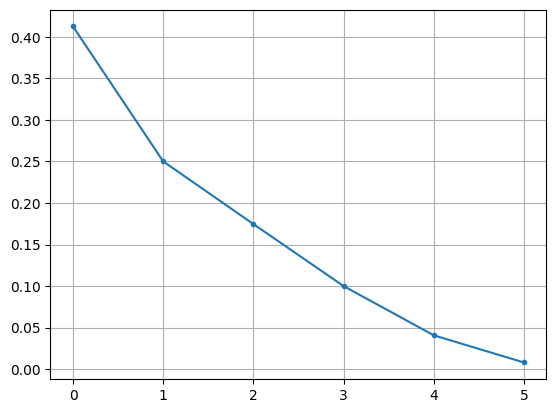

In [80]:
s = pd.Series((td_train["actions"] != 0).float().mean(dim=0))
s = s.groupby(s.index // 3).mean()
s = s[s.index % 2 == 0]
s.reset_index(inplace=True, drop=True)
s.plot(marker=".", grid=True)

In [87]:
s.shift(-1) / s

0    0.606294
1    0.698340
2    0.572460
3    0.407407
4    0.196803
5         NaN
dtype: float32